<a href="https://colab.research.google.com/github/inesdarosa/Series_temporales/blob/main/ancapC7_univariada_multistep_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
 
files.upload()

Multistep Time Series Forecasting with LSTMs in Python

https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/

In [6]:
import pandas as pd

In [7]:
dataset = pd.read_csv('C7_2022_mean.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)

In [8]:
dataset.head()

Fecha
2017-11-13    1.58
2017-11-14    0.87
2017-11-16    1.29
2017-11-17    1.90
2017-11-19    0.68
Name: Contenido_C7_Total, dtype: float64

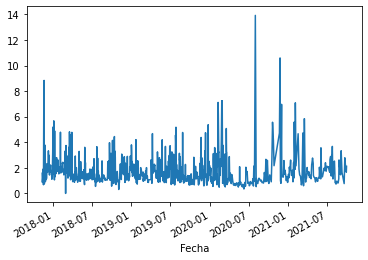

In [9]:
from matplotlib import pyplot
dataset.plot()
pyplot.show()

In [10]:
# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [11]:
# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	raw_values = raw_values.reshape(len(raw_values), 1)
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(raw_values, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return train, test

In [12]:
from pandas import DataFrame
from pandas import concat

In [13]:
n_lag = 1
n_seq = 3
n_test = 450
# prepare data
train, test = prepare_data(dataset, n_test, n_lag, n_seq)
print(test)
print('Train: %s, Test: %s' % (train.shape, test.shape))

[[1.19 1.8  1.04 0.98]
 [1.8  1.04 0.98 1.02]
 [1.04 0.98 1.02 1.44]
 ...
 [1.64 0.77 2.79 2.  ]
 [0.77 2.79 2.   1.66]
 [2.79 2.   1.66 2.12]]
Train: (572, 4), Test: (450, 4)


In [14]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [15]:
# make a persistence forecast
def persistence(last_ob, n_seq):
	return [last_ob for i in range(n_seq)]

In [18]:
# evaluate the persistence model
def make_forecasts(train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = persistence(X[-1], n_seq)
		# store the forecast
		forecasts.append(forecast)
	return forecasts

In [19]:
# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = test[:,(n_lag+i)]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))

In [29]:
# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i
		off_e = off_s + len(forecasts[i])
		xaxis = [x for x in range(off_s, off_e)]
		pyplot.plot(xaxis, forecasts[i], color='red')
	# show the plot
	pyplot.show()

In [ ]:
# plot forecasts
# plot_forecasts(series, forecasts, 12)

In [33]:
# plot the forecasts in the context of the original dataset
def plot_forecasts_1(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - 365 + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
		pyplot.plot(xaxis, yaxis, color='red')
	# show the plot
	pyplot.show()

In [22]:
forecasts = make_forecasts(train, test, n_lag, n_seq)

In [23]:
evaluate_forecasts(test, forecasts, n_lag, n_seq)

t+1 RMSE: 1.532841
t+2 RMSE: 1.678893
t+3 RMSE: 1.740604


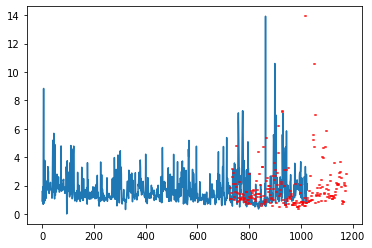

In [31]:
# plot forecasts
plot_forecasts(dataset, forecasts, 300)

IndexError: ignored

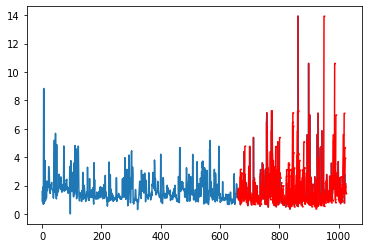

In [34]:
plot_forecasts_1(dataset, forecasts, 300)

In [46]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


In [37]:
# ahora pasos para la multistep lstm
# esta función tiene en una parte la eliminación de la tendencia, pero en este caso la saco porque la serie no presenta tendencia

# transform series into train and test sets for supervised learning
# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	#raw_values = series.values
	# transform data to be stationary
	#diff_series = difference(raw_values, 1)
	dataset_values = series.values
	dataset_values = dataset_values.reshape(len(dataset_values), 1)
	# rescale values to -1, 1
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaled_values = scaler.fit_transform(dataset_values)
	scaled_values = scaled_values.reshape(len(scaled_values), 1)
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(scaled_values, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return scaler, train, test

In [38]:
# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
	# reshape training into [samples, timesteps, features]
	X, y = train[:, 0:n_lag], train[:, n_lag:]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	# design network
	model = Sequential()
	model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(y.shape[1]))
	model.compile(loss='mean_squared_error', optimizer='adam')
	# fit network
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
		model.reset_states()
	return model

In [39]:
# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
	# reshape input pattern to [samples, timesteps, features]
	X = X.reshape(1, 1, len(X))
	# make forecast
	forecast = model.predict(X, batch_size=n_batch)
	# convert to array
	return [x for x in forecast[0, :]]

In [40]:
# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = forecast_lstm(model, X, n_batch)
		# store the forecast
		forecasts.append(forecast)
	return forecasts

In [41]:
# invert differenced forecast
def inverse_difference(last_ob, forecast):
	# invert first forecast
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	# propagate difference forecast using inverted first value
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + inverted[i-1])
	return inverted

In [42]:
# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
	inverted = list()
	for i in range(len(forecasts)):
		# create array from forecast
		forecast = array(forecasts[i])
		forecast = forecast.reshape(1, len(forecast))
		# invert scaling
		inv_scale = scaler.inverse_transform(forecast)
		inv_scale = inv_scale[0, :]
		# invert differencing
		index = len(series) - n_test + i - 1
		last_ob = series.values[index]
		inv_diff = inverse_difference(last_ob, inv_scale)
		# store
		inverted.append(inv_diff)
	return inverted

In [43]:
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))

In [44]:
# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
		pyplot.plot(xaxis, yaxis, color='red')
	# show the plot
	pyplot.show()

1/1 [==============================] - 0s 17ms/step
t+1 RMSE: 0.856116
t+2 RMSE: 1.456634
t+3 RMSE: 1.937676
t+4 RMSE: 2.345908
t+5 RMSE: 2.707432
t+6 RMSE: 3.024610
t+7 RMSE: 3.317490
t+8 RMSE: 3.591053
t+9 RMSE: 3.848710
t+10 RMSE: 4.088898
t+11 RMSE: 4.312780
t+12 RMSE: 4.521564
t+13 RMSE: 4.722267
t+14 RMSE: 4.922802
t+15 RMSE: 5.125915
t+16 RMSE: 5.338924
t+17 RMSE: 5.551316
t+18 RMSE: 5.751951
t+19 RMSE: 5.947698
t+20 RMSE: 6.139007
t+21 RMSE: 6.326262
t+22 RMSE: 6.506886
t+23 RMSE: 6.686162
t+24 RMSE: 6.858510
t+25 RMSE: 7.022239
t+26 RMSE: 7.177444
t+27 RMSE: 7.325049
t+28 RMSE: 7.467409
t+29 RMSE: 7.602094
t+30 RMSE: 7.730192
t+31 RMSE: 7.850389
t+32 RMSE: 7.970586
t+33 RMSE: 8.104693
t+34 RMSE: 8.257456
t+35 RMSE: 8.432061
t+36 RMSE: 8.623888
t+37 RMSE: 8.825347
t+38 RMSE: 9.032104
t+39 RMSE: 9.226536
t+40 RMSE: 9.417612
t+41 RMSE: 9.610982
t+42 RMSE: 9.808146
t+43 RMSE: 10.009437
t+44 RMSE: 10.220604
t+45 RMSE: 10.442770
t+46 RMSE: 10.668752
t+47 RMSE: 10.894994
t+48 RMSE: 1

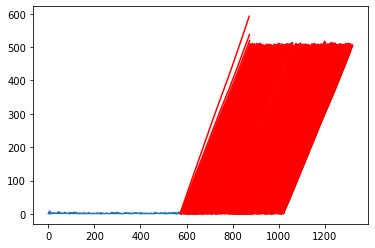

In [49]:
n_lag = 1
n_seq = 300
n_test = 450
n_epochs = 150
n_batch = 1
n_neurons = 1
# prepare data
scaler, train, test = prepare_data(dataset, n_test, n_lag, n_seq)
# fit model
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
# make forecasts
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
# inverse transform forecasts and test
forecasts = inverse_transform(dataset, forecasts, scaler, n_test+2)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(dataset, actual, scaler, n_test+2)
# evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)
# plot forecasts
plot_forecasts(dataset, forecasts, n_test+2)